# BPZ RAIL 

## imports

In [36]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline 

In [37]:
import rail
import qp
import tables_io

from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

from rail.creation.degradation import LSSTErrorModel, InvRedshiftIncompleteness, LineConfusion, QuantityCut
from rail.creation.engines.flowEngine import FlowEngine, FlowPosterior

from rail.estimation.algos.bpz_lite import Inform_BPZ_lite, BPZ_lite

from rail.evaluation.evaluator import Evaluator

In [38]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

os.getcwd()

'/home/heloisamengisztki/bpz_test_rail'

In [39]:
RAIL_DIR = os.path.join(os.path.dirname(rail.__file__), '..')
flow_file_path = os.path.join(RAIL_DIR, 'examples/goldenspike/data/pretrained_flow.pkl')

print(RAIL_DIR)
pd.read_pickle(flow_file_path)['data_columns']

/home/heloisamengisztki/.local/lib/python3.10/site-packages/rail/..


('mag_z_lsst',
 'mag_y_lsst',
 'mag_r_lsst',
 'mag_i_lsst',
 'redshift',
 'mag_u_lsst',
 'mag_g_lsst')

In [40]:
bands = ['u','g','r','i','z','y']
band_dict = {band:f'mag_{band}_lsst' for band in bands}
rename_dict = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

## Train -> criação de dados fakes (prior)

In [43]:
flow_engine_train = FlowEngine.make_stage(name='flow_engine_train', flow=flow_file_path, n_samples=50, seed=1235)
#help(FlowEngine)
lsst_error_model_train = LSSTErrorModel.make_stage(name='lsst_error_model_train', bandNames=band_dict, seed=29)

inv_redshift = InvRedshiftIncompleteness.make_stage(name='inv_redshift', pivot_redshift=1.0)

line_confusion = LineConfusion.make_stage(name='line_confusion', true_wavelen=5007., wrong_wavelen=3727., frac_wrong=0.05)

quantity_cut = QuantityCut.make_stage(name='quantity_cut', cuts={'mag_i_lsst': 25.0})

col_remapper_train = ColumnMapper.make_stage(name='col_remapper_train', columns=rename_dict)
   
table_conv_train = TableConverter.make_stage(name='table_conv_train', output_format='numpyDict')

In [44]:
train_data_orig = flow_engine_train.sample(3500, 1235)
#help(flow_engine_train.sample)
train_data_errs = lsst_error_model_train(train_data_orig, seed=66)
train_data_inc = inv_redshift(train_data_errs)
train_data_conf = line_confusion(train_data_inc)
train_data_cut = quantity_cut(train_data_conf)
train_data_pq = col_remapper_train(train_data_cut)
train_data = table_conv_train(train_data_pq)

Inserting handle into data store.  output_flow_engine_train: inprogress_output_flow_engine_train.pq, flow_engine_train
Inserting handle into data store.  output_lsst_error_model_train: inprogress_output_lsst_error_model_train.pq, lsst_error_model_train
Inserting handle into data store.  output_inv_redshift: inprogress_output_inv_redshift.pq, inv_redshift
Inserting handle into data store.  output_line_confusion: inprogress_output_line_confusion.pq, line_confusion
Inserting handle into data store.  output_quantity_cut: inprogress_output_quantity_cut.pq, quantity_cut
Inserting handle into data store.  output_col_remapper_train: inprogress_output_col_remapper_train.pq, col_remapper_train
Inserting handle into data store.  output_table_conv_train: inprogress_output_table_conv_train.hdf5, table_conv_train


In [45]:
train_table = tables_io.convertObj(train_data.data, tables_io.types.PD_DATAFRAME)
train_table.head()

,mag_z_lsst,mag_err_z_lsst,mag_y_lsst,mag_err_y_lsst,mag_r_lsst,mag_err_r_lsst,mag_i_lsst,mag_err_i_lsst,redshift,mag_u_lsst,mag_err_u_lsst,mag_g_lsst,mag_err_g_lsst
0,19.769253,0.005056,19.658558,0.005191,20.305207,0.005025,19.980174,0.005030,0.104548,22.417556,0.009758,21.013387,0.005084
1,24.440543,0.041466,24.426331,0.093220,25.648450,0.046298,24.918123,0.035917,0.982259,26.202344,0.227130,26.054119,0.067495
2,24.259645,0.035332,24.295798,0.083105,24.454956,0.016452,24.344782,0.021773,0.319286,25.449641,0.119878,25.095253,0.028940
3,24.151705,0.032124,24.045327,0.066602,25.488254,0.040165,24.563846,0.026312,0.918919,26.349170,0.256313,25.928132,0.060373
4,23.112471,0.013387,23.072345,0.028162,23.525294,0.008435,23.264030,0.009433,0.348853,25.598024,0.136254,24.575652,0.018547


## Estimator -> definição de PRIORS

In [46]:
inform_bpz = Inform_BPZ_lite.make_stage(name='inform_bpzlite', input='inprogress_output_table_conv_train.hdf5',
                                        model='trained_BPZ_output.pkl', hdf5_groupname='', nt_array=[8],
                                        mmax=26., type_file='')
inform_bpz.config.to_dict()

{'output_mode': 'default',
 'hdf5_groupname': '',
 'save_train': True,
 'zmin': 0.0,
 'zmax': 3.0,
 'nzbins': 301,
 'band_names': ['mag_u_lsst',
  'mag_g_lsst',
  'mag_r_lsst',
  'mag_i_lsst',
  'mag_z_lsst',
  'mag_y_lsst'],
 'band_err_names': ['mag_err_u_lsst',
  'mag_err_g_lsst',
  'mag_err_r_lsst',
  'mag_err_i_lsst',
  'mag_err_z_lsst',
  'mag_err_y_lsst'],
 'nondetect_val': 99.0,
 'data_path': 'None',
 'columns_file': './examples/estimation/configs/test_bpz.columns',
 'spectra_file': 'SED/CWWSB4.list',
 'm0': 20.0,
 'nt_array': [8],
 'mmin': 18.0,
 'mmax': 26.0,
 'init_kt': 0.3,
 'init_zo': 0.4,
 'init_alpha': 1.8,
 'init_km': 0.1,
 'prior_band': 'mag_i_lsst',
 'redshift_col': 'redshift',
 'type_file': '',
 'name': 'inform_bpzlite',
 'input': 'inprogress_output_table_conv_train.hdf5',
 'model': 'trained_BPZ_output.pkl',
 'config': None,
 'aliases': {'model': 'model_inform_bpzlite'}}

In [42]:
%%time
inform_bpz.inform(train_data)

using 3197 galaxies in calculation
best values for fo and kt:
[1.]
[0.3]
minimizing for type 0
[0.4 1.8 0.1] 1361.5365905838048
[0.42 1.8  0.1 ] 1406.934694854976
[0.4  1.89 0.1 ] 1331.9315266391309
[0.4   1.8   0.105] 1398.1635937264132
[0.38       1.86       0.10333333] 1324.5315878093197
[0.36  1.89  0.105] 1301.243099140332
[0.37333333 1.92       0.09833333] 1293.0238907158487
[0.36  1.98  0.095] 1308.6083983364533
[0.35555556 2.         0.10222222] 1302.5914418321813
[0.32592593 1.98333333 0.1037037 ] 1318.3061464536004
[0.34444444 1.96       0.10277778] 1296.8726363551486
[0.36296296 1.84666667 0.10185185] 1299.2504735398695
[0.36049383 1.92777778 0.09697531] 1290.8877289127731
[0.36074074 1.94666667 0.09296296] 1303.438424862155
[0.35588477 2.02518519 0.09687243] 1323.967167879751
[0.36119342 1.8912963  0.100607  ] 1290.4761462853844
[0.38556927 1.86604938 0.09449931] 1296.135836538358
[0.37528807 1.88953704 0.09656893] 1291.3799265104517
[0.35798354 1.88574074 0.09776749] 1286.

NOTE/WARNING: Expected output file trained_BPZ_output.pkl was not generated.


## Test -> criação de dados fakes

In [11]:
#help(FlowEngine)
flow_engine_test = FlowEngine.make_stage(name='flow_engine_test', flow=flow_file_path, n_samples=50)

lsst_error_model_test = LSSTErrorModel.make_stage(name='lsst_error_model_test', bandNames=band_dict)
                
col_remapper_test = ColumnMapper.make_stage(name='col_remapper_test', columns=rename_dict)

table_conv_test = TableConverter.make_stage(name='table_conv_test', output_format='numpyDict')

In [12]:
test_data_orig = flow_engine_test.sample(3500, 1234)
test_data_errs = lsst_error_model_test(test_data_orig, seed=58)
test_data_pq = col_remapper_test(test_data_errs)
#test_data_post = flow_post_test.get_posterior(test_data_pq, 'redshift', err_samples=None)
test_data = table_conv_test(test_data_pq)

Inserting handle into data store.  output_flow_engine_test: inprogress_output_flow_engine_test.pq, flow_engine_test
Inserting handle into data store.  output_lsst_error_model_test: inprogress_output_lsst_error_model_test.pq, lsst_error_model_test
Inserting handle into data store.  output_col_remapper_test: inprogress_output_col_remapper_test.pq, col_remapper_test
Inserting handle into data store.  output_table_conv_test: inprogress_output_table_conv_test.hdf5, table_conv_test


In [13]:
test_table = tables_io.convertObj(test_data.data, tables_io.types.PD_DATAFRAME)
test_table.head()

,mag_z_lsst,mag_err_z_lsst,mag_y_lsst,mag_err_y_lsst,mag_r_lsst,mag_err_r_lsst,mag_i_lsst,mag_err_i_lsst,redshift,mag_u_lsst,mag_err_u_lsst,mag_g_lsst,mag_err_g_lsst
0,22.568797,0.009116,22.438612,0.016416,23.071886,0.006756,22.753930,0.007126,0.353574,24.780910,0.066830,23.982392,0.011628
1,23.586637,0.019695,23.083295,0.028433,25.509427,0.040926,24.473265,0.024321,1.105480,27.416228,0.582621,27.086897,0.166030
2,23.709599,0.021867,23.484410,0.040493,24.708495,0.020335,24.361161,0.022081,1.118809,24.841946,0.070512,25.140974,0.030120
3,23.914696,0.026104,23.867371,0.056880,24.880799,0.023570,24.207980,0.019382,0.487630,27.624507,0.673923,26.289809,0.083104
4,24.133260,0.031607,24.060429,0.067499,24.661489,0.019541,24.370091,0.022251,0.133360,26.810597,0.370640,25.252920,0.033227


## Posterior -> Handler -> roda o algoritmo


In [73]:
estimate_bpz = BPZ_lite.make_stage(name='estimate_bpz', hdf5_groupname='',
                                   columns_file='/home/heloisamengisztki/bpz_test_rail/configs/test_bpz.columns',
                                   model = inform_bpz.get_handle('model'))

KeyError: 'todict'

In [47]:
bpz_estimated = estimate_bpz.estimate(test_data)

Process 0 running estimator on chunk 0 - 3500
Inserting handle into data store.  output_estimate_bpz: inprogress_output_estimate_bpz.hdf5, estimate_bpz


In [69]:
#help(bpz_estimated())
bpz_estimated().build_tables()

#results_tables = tables_io.convertObj(bpz_estimated().build_tables()['ancil'], tables_io.types.PD_DATAFRAME)
#results_tables

{'meta': {'pdf_name': array([b'interp'], dtype='|S6'),
  'pdf_version': array([0]),
  'xvals': array([[0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
          0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
          0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
          0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
          0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
          0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
          0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
          0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
          0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
          0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
          1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
          1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1

In [16]:
the_eval = Evaluator.make_stage(name=f'bpz_eval', truth=test_data_orig)
print(bpz_estimated, test_data_orig)
result_dict = the_eval.evaluate(bpz_estimated, test_data_orig)

<class 'rail.core.data.QPHandle'> output_estimate_bpz.hdf5, (wd) <class 'rail.core.data.PqHandle'> output_flow_engine_test.pq, (wd)
129 PITs removed from the sample.


/home/heloisamengisztki/.local/lib/python3.10/site-packages/rail/evaluation/metrics/pit.py:188: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Inserting handle into data store.  output_bpz_eval: inprogress_output_bpz_eval.hdf5, bpz_eval
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'
Warning.  Failed to convert column 'list' object has no attribute 'dtype'


In [17]:
results_tables = tables_io.convertObj(result_dict.data, tables_io.types.PD_DATAFRAME)
results_tables.head()

,PIT_KS_stat,PIT_KS_pval,PIT_CvM_stat,PIT_CvM_pval,PIT_OutRate,POINT_SimgaIQR,POINT_Bias,POINT_OutlierRate,POINT_SigmaMAD,CDE_stat,CDE_pval
0,NaN,NaN,NaN,1.0,NaN,0.05113,-0.030923,0.122857,0.051071,NaN,NaN


## Resultado pz x spec-z

In [18]:
zmode = bpz_estimated().ancil['zmode']

Text(0, 0.5, 'bpz photo-z')

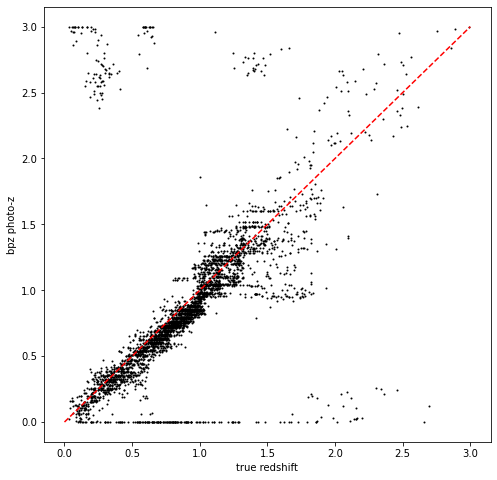

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['redshift'],zmode,s=1,c='k',label='simple bpz mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("bpz photo-z")

## PIT separado (teste)

In [70]:
from rail.evaluation.metrics.pit import *
from rail.core.data import QPHandle, TableHandle

output_dir = os.path.join('/home/heloisamengisztki/bpz_test_rail/')
pdfs_file =  os.path.join(output_dir, "output_estimate_bpz.hdf5")

ztrue = test_data_orig()['redshift']
fzdata = DS.read_file('pdfs_data', QPHandle, pdfs_file)

pitobj = PIT(fzdata(), ztrue)
quant_ens, metamets = pitobj.evaluate()
print(quant_ens, metamets)

129 PITs removed from the sample.
<qp.ensemble.Ensemble object at 0x7fcee057fdc0> {(<class 'rail.evaluation.metrics.pit.PITOutRate'>, 'default'): nan, (<class 'rail.evaluation.metrics.pit.PITAD'>, 'default'): stat_crit_sig(statistic=1132.2731391559544, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)}


/home/heloisamengisztki/.local/lib/python3.10/site-packages/rail/evaluation/metrics/pit.py:188: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


In [71]:
pit_vals = np.array(pitobj._pit_samps)
print(pit_vals)

pit_out_rate = PITOutRate(pit_vals, quant_ens).evaluate()
print(f"PIT outlier rate of this sample: {pit_out_rate}") 

[0.3537954  1.         0.         ... 0.61345317 1.         0.9639759 ]
PIT outlier rate of this sample: nan


[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan 

Text(0, 0.5, 'p(z)')

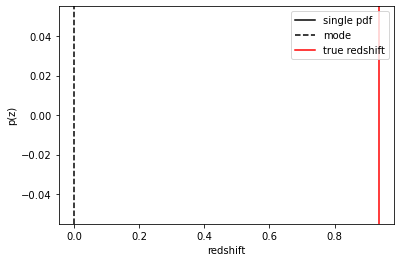

In [72]:
galid = 1500

zgrid = np.linspace(0, 3., 301)
single_gal = np.squeeze(bpz_estimated()[galid].pdf(zgrid))
print(bpz_estimated()[galid].pdf(zgrid))
single_zmode = zmode[galid]
truez = test_data()['redshift'][galid]

plt.plot(zgrid,single_gal,color='k',label='single pdf')
plt.axvline(single_zmode,color='k', ls='--', label='mode')
plt.axvline(truez,color='r',label='true redshift')
plt.legend(loc='upper right')
plt.xlabel("redshift")
plt.ylabel("p(z)")